<div style="background: #f0f8ff; padding: 20px; border-left: 5px solid #3498db; border-radius: 10px; font-family: 'Segoe UI', sans-serif; text-align: center;">

<h2 style="color: #2c3e50; margin-bottom: 15px;">
  📘 Báo cáo phương pháp và kế hoạch triển khai chiến lược đầu tư
</h2>

<p style="font-size: 16px; line-height: 1.6; color: #34495e; display: inline-block; text-align: justify; max-width: 800px;">
  <strong>Mục tiêu:</strong> Xây dựng một chiến lược phân bổ vốn linh hoạt theo từng tháng (dưới dạng ma trận trọng số 12x4) nhằm tối đa hóa lợi nhuận đã điều chỉnh theo rủi ro cho danh mục 4 tài sản trong 12 tháng.
</p>

</div>


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

### 1. Lý giải phương pháp luận: Tối ưu hóa danh mục đa kỳ (Multi-Period Optimization)

#### **1.1. Vấn đề cốt lõi**
Bài toán yêu cầu một chiến lược **linh hoạt**, tức là quyết định phân bổ vốn không phải là một quyết định duy nhất ban đầu mà được điều chỉnh định kỳ (đầu mỗi tháng). Mục tiêu không chỉ là lợi nhuận cao nhất mà còn phải cân bằng với rủi ro chấp nhận được.

#### **1.2. Giải pháp đề xuất: Tối ưu hóa Trung bình-Phương sai (Mean-Variance Optimization - MVO) của Markowitz**
Đây là phương pháp nền tảng và phù hợp nhất cho bài toán này vì:
* **Giải quyết đúng mục tiêu**: MVO tập trung vào việc tìm kiếm danh mục đầu tư có **tỷ suất sinh lợi kỳ vọng cao nhất** cho một **mức rủi ro nhất định** (hoặc rủi ro thấp nhất cho một mức lợi nhuận nhất định). Điều này hoàn toàn khớp với mục tiêu cân bằng Lợi nhuận-Rủi ro của đề bài.
* **Cung cấp quyết định định lượng**: Thay vì dựa vào cảm tính, MVO cung cấp một vector trọng số (`w`) được tính toán dựa trên các dữ liệu thống kê, giúp quyết định phân bổ vốn trở nên khách quan.
* **Phù hợp với chiến lược đa kỳ**: Bằng cách áp dụng lặp lại thuật toán MVO vào đầu mỗi tháng với dữ liệu cập nhật, chúng ta có thể xây dựng được ma trận trọng số 12x4 một cách logic. Mỗi cột trong ma trận chính là kết quả của một bài toán tối ưu hóa tại một thời điểm.


### 2. Cấu trúc và Kế hoạch triển khai

Mô hình sẽ được xây dựng dựa trên 3 module chính: **Dự báo**, **Tối ưu hóa**, và **Mô phỏng**.



#### **Module 1: Module Dự báo (Forecasting)**
*Mục đích: Ước tính các tham số cần thiết cho việc ra quyết định ở tháng tiếp theo.*



* **Công việc 1.1: `load_and_preprocess_data()`**
    * **Mô tả**: Tải dữ liệu từ file `cleaned_data.csv`, đây là data đã được làm sạch qua các bước.
    * **Xử lý Missing Values**: Áp dụng các phương pháp đã phân tích trong file `EDA.ipynb`, bao gồm:
        * Điền giá trị ngày Thứ 6 cho các ngày cuối tuần bị thiếu.
        * Sử dụng nội suy tuyến tính (linear interpolation) để điền các giá trị thiếu trong tuần.

In [51]:
import os
BASE_DIR = os.path.dirname(os.getcwd())
dataset_path = os.path.join(BASE_DIR, 'data', 'cleaned_data.csv')

# Load the dataset
df = pd.read_csv(dataset_path,  encoding='utf-8', parse_dates=['Time'])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    390 non-null    datetime64[ns]
 1   Crypto                  390 non-null    float64       
 2   Buying_Price_of_Nexus   390 non-null    float64       
 3   Selling_Price_of_Nexus  390 non-null    float64       
 4   Price_of_Stock          390 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.4 KB


---

* **Công việc 1.2: `calculate_log_returns(price_data)`**
    * **Mô tả**: Tính toán chuỗi tỷ suất sinh lợi log hàng ngày cho các tài sản rủi ro (Crypto, Nexus, Stock). Đây là đầu vào cơ bản để đo lường lợi nhuận và rủi ro.


In [53]:
def calculate_log_returns(
    df,
    price_cols=['Crypto', 'Buying_Price_of_Nexus', 'Selling_Price_of_Nexus', 'Price_of_Stock'],
    annualization_factors={
        'Crypto': 365,
        'Buying_Price_of_Nexus': 252,
        'Price_of_Stock': 252
    },
    return_log_returns=False  # Cho phép trả thêm log returns nếu cần
):
    """
    Tính tỷ suất sinh lợi log và độ biến động hàng năm cho các cột giá.

    Parameters:
        df (pd.DataFrame): DataFrame chứa các cột giá.
        price_cols (list): Danh sách các tên cột giá cần tính toán.
        annualization_factors (dict): Từ điển ánh xạ tên cột -> hệ số quy đổi năm.
        return_log_returns (bool): Nếu True thì trả thêm log return hàng ngày.

    Returns:
        dict: annualized volatility
        (Optional) pd.DataFrame: log returns hàng ngày
    """
    volatility_results = {}
    log_returns_df = pd.DataFrame(index=df.index)  # NEW

    print("--- Độ biến động (Volatility) ---")
    print(f"Sử dụng hệ số: Crypto={annualization_factors.get('Crypto', 'N/A')}, "
          f"Cổ phiếu/Nexus={annualization_factors.get('Price_of_Stock', 'N/A')}\n")

    for col in price_cols:
        log_returns = np.log(df[col] / df[col].shift(1))
        log_returns_df[col] = log_returns  # NEW

        daily_volatility = log_returns.std()
        factor = annualization_factors.get(col, 252)
        annualized_volatility = daily_volatility * np.sqrt(factor)

        volatility_results[col] = annualized_volatility
        print(f"{col:<25}: {annualized_volatility:.2%}")

    if return_log_returns:
        return volatility_results, log_returns_df  # Trả cả hai
    else:
        return volatility_results

In [54]:
volatility = calculate_log_returns(df)

--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 93.28%
Buying_Price_of_Nexus    : 9.11%
Selling_Price_of_Nexus   : 9.26%
Price_of_Stock           : 33.04%


---

* **Công việc 1.3: `forecast_monthly_params(data_window)`**
    * **Mô tả**: Hàm này sẽ là trái tim của module dự báo. Nó nhận vào một "cửa sổ" dữ liệu lịch sử (ví dụ: 90 ngày gần nhất) và tính toán:
        1.  **Vector lợi nhuận kỳ vọng tháng (μ)**: Bằng cách lấy trung bình của log return hàng ngày và nhân với 30.
        2.  **Ma trận hiệp phương sai tháng (Σ)**: Tính toán ma trận hiệp phương sai của log return hàng ngày và nhân với 30. Ma trận này thể hiện rủi ro của từng tài sản và mối tương quan giữa chúng.

In [55]:
def forecast_monthly_params(data_window):
    """
    Dự báo vector lợi nhuận kỳ vọng và ma trận hiệp phương sai cho tháng tiếp theo
    dựa trên một cửa sổ dữ liệu lịch sử.

    Parameters:
        data_window (pd.DataFrame): DataFrame chứa dữ liệu giá lịch sử
                                     cho một khoảng thời gian (ví dụ: 90 ngày).

    Returns:
        tuple: (mu, sigma)
            - mu (pd.Series): Vector lợi nhuận kỳ vọng tháng của các tài sản.
            - sigma (pd.DataFrame): Ma trận hiệp phương sai tháng của các tài sản.
    """
    price_cols = ['Crypto', 'Buying_Price_of_Nexus', 'Selling_Price_of_Nexus' , 'Price_of_Stock']

    # Gọi lại hàm calculate_log_returns để tận dụng phần tính toán log return
    _, log_returns_daily = calculate_log_returns(
        data_window,
        price_cols=price_cols,
        return_log_returns=True  # Rất quan trọng!
    )

    # Vector lợi nhuận kỳ vọng tháng
    mu = log_returns_daily.mean() * 30

    # Ma trận hiệp phương sai tháng
    sigma = log_returns_daily.cov() * 30

    return mu, sigma

In [56]:
# Lấy ra cửa sổ dữ liệu 90 ngày cuối cùng để dự báo
data_window_example = df.head(90)

# Gọi hàm để lấy tham số dự báo
mu_forecasted, sigma_forecasted = forecast_monthly_params(data_window_example, )

# In kết quả
print("--- Vector Lợi nhuận kỳ vọng tháng (μ) ---")
display(mu_forecasted)

print("\n--- Ma trận Hiệp phương sai tháng (Σ) ---")
display(sigma_forecasted)

--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 95.45%
Buying_Price_of_Nexus    : 9.93%
Selling_Price_of_Nexus   : 10.03%
Price_of_Stock           : 29.08%
--- Vector Lợi nhuận kỳ vọng tháng (μ) ---


Crypto                    0.221304
Buying_Price_of_Nexus    -0.002584
Selling_Price_of_Nexus   -0.001958
Price_of_Stock            0.036943
dtype: float64


--- Ma trận Hiệp phương sai tháng (Σ) ---


,Crypto,Buying_Price_of_Nexus,Selling_Price_of_Nexus,Price_of_Stock
Crypto,0.074875,0.001387,0.001220,0.000230
Buying_Price_of_Nexus,0.001387,0.001173,0.001159,0.000548
Selling_Price_of_Nexus,0.001220,0.001159,0.001198,0.000653
Price_of_Stock,0.000230,0.000548,0.000653,0.010065


---


#### **Module 2: Module Tối ưu hóa (Optimization)**
*Mục đích: Tìm ra vector trọng số phân bổ vốn tối ưu cho mỗi tháng.*

* **Công việc 2.1: `optimize_weights(mu, sigma, transaction_costs)`**
    * **Mô tả**: Hàm này triển khai thuật toán Tối ưu hóa Markowitz.
    * **Hàm mục tiêu**: Tối đa hóa **Tỷ lệ Sharpe** (`Lợi nhuận danh mục / Độ lệch chuẩn danh mục`). Việc này giúp tìm ra danh mục hiệu quả nhất trên mỗi đơn vị rủi ro.
    * **Ràng buộc**:
        * Tổng các trọng số (`w_i`) phải bằng 1.
        * Mỗi trọng số phải lớn hơn hoặc bằng 0 (không bán khống).
        * Chi phí giao dịch (0.15% cho Crypto/Stock, chênh lệch giá mua-bán cho Nexus) sẽ được tích hợp để điều chỉnh lợi nhuận kỳ vọng.

In [57]:
def optimize_weights(mu, sigma, risk_free_rate=0.075/12):
    """
    Tìm ra vector trọng số tối ưu để tối đa hóa Tỷ lệ Sharpe, dựa trên
    lợi nhuận kỳ vọng (mu), ma trận hiệp phương sai (sigma), và lãi suất phi rủi ro.

    Parameters:
        mu (pd.Series): Vector lợi nhuận kỳ vọng tháng của các tài sản.
        sigma (pd.DataFrame): Ma trận hiệp phương sai tháng của các tài sản.
        risk_free_rate (float): Lãi suất phi rủi ro hàng tháng. Mặc định là 7.5%/năm.

    Returns:
        np.array: Vector trọng số tối ưu cho danh mục.
    """
    num_assets = len(mu)

    # Hàm mục tiêu: Tối thiểu hóa ÂM của Tỷ lệ Sharpe
    # Sharpe Ratio = (Lợi nhuận danh mục - Lãi suất phi rủi ro) / Độ biến động danh mục
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(mu * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio

    # Ràng buộc và giới hạn cho các trọng số (weights)
    # 1. Tổng các trọng số phải bằng 1 (phân bổ hết 100% vốn)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # 2. Mỗi trọng số phải nằm trong khoảng từ 0 đến 1 (không bán khống, không dùng đòn bẩy)
    bounds = tuple((0.0, 1.0) for _ in range(num_assets))

    # 3. Điểm khởi đầu cho thuật toán tối ưu hóa (ví dụ: phân bổ đều)
    initial_weights = num_assets * [1. / num_assets]

    # Chạy thuật toán tối ưu hóa (SLSQP là phương pháp phù hợp cho bài toán này)
    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x # result.x chính là array chứa các trọng số tối ưu

In [58]:
# Lãi suất phi rủi ro hàng tháng (từ 7.5% APR)
# Có thể điều chỉnh kỳ hạn k vào đây nếu cần, ví dụ: risk_free_rate = (1 + 0.075/12)**k -1
monthly_risk_free_rate = 0.075 / 12 

# Bỏ cột Selling_Price_of_Nexus vì nó tương quan rất cao với Buying_Price
# và ta chỉ cần một đại diện cho Nexus
mu_for_opt = mu_forecasted.drop('Selling_Price_of_Nexus')
sigma_for_opt = sigma_forecasted.drop(columns='Selling_Price_of_Nexus').drop('Selling_Price_of_Nexus')


# Gọi hàm tối ưu hóa
optimal_weights = optimize_weights(mu_for_opt, sigma_for_opt, monthly_risk_free_rate)

# In kết quả trọng số tối ưu
print("--- Tỷ trọng phân bổ vốn tối ưu cho tháng tới ---")
optimal_df = pd.DataFrame(data={'Weight': optimal_weights}, index=mu_for_opt.index)
print((optimal_df * 100).round(2).to_string(float_format="%.2f%%"))


# (Tùy chọn) In ra hiệu suất kỳ vọng của danh mục tối ưu này
expected_return = np.sum(mu_for_opt * optimal_weights)
expected_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(sigma_for_opt, optimal_weights)))
expected_sharpe = (expected_return - monthly_risk_free_rate) / expected_volatility

print("\n--- Hiệu suất kỳ vọng của danh mục tối ưu ---")
print(f"Lợi nhuận kỳ vọng tháng: {expected_return:.2%}")
print(f"Độ biến động (rủi ro) tháng: {expected_volatility:.2%}")
print(f"Tỷ lệ Sharpe kỳ vọng: {expected_sharpe:.2f}")

--- Tỷ trọng phân bổ vốn tối ưu cho tháng tới ---
                       Weight
Crypto                 49.03%
Buying_Price_of_Nexus   0.00%
Price_of_Stock         50.97%

--- Hiệu suất kỳ vọng của danh mục tối ưu ---
Lợi nhuận kỳ vọng tháng: 12.73%
Độ biến động (rủi ro) tháng: 14.40%
Tỷ lệ Sharpe kỳ vọng: 0.84


---

#### Module 3

In [59]:
def run_backtest(
    historical_df,
    initial_capital,
    forecast_func,
    optimizer_func,
    train_window_size=60,
    test_months=12,
    days_per_month=30
):
    """
    Thực hiện kiểm thử quá khứ (backtesting) theo phương pháp cửa sổ trượt.

    Parameters:
        historical_df (pd.DataFrame): Toàn bộ dữ liệu lịch sử đã được làm sạch.
        initial_capital (float): Vốn ban đầu.
        forecast_func (function): Hàm dự báo (forecast_monthly_params).
        optimizer_func (function): Hàm tối ưu hóa (optimize_weights).
        train_window_size (int): Kích thước cửa sổ ban đầu để training.
        test_months (int): Số tháng cần kiểm thử.
    
    Returns:
        tuple: (capital_history, weights_history)
            - capital_history (pd.Series): Lịch sử giá trị danh mục qua từng tháng.
            - weights_history (pd.DataFrame): Lịch sử trọng số danh mục qua từng tháng.
    """
    capital = initial_capital
    
    # Giả định bắt đầu bằng tiền mặt, nên trọng số ban đầu là 0
    # Cột 'Time' đã được set làm index
    price_cols = ['Crypto', 'Buying_Price_of_Nexus', 'Price_of_Stock']
    current_weights = np.array([0.0] * len(price_cols))
    
    # Chi phí giao dịch (giả định cho Nexus là 0, sẽ xử lý sau)
    transaction_costs = {'Crypto': 0.0015, 'Price_of_Stock': 0.0015, 'Buying_Price_of_Nexus': 0}
    
    # Lists để lưu lịch sử
    capital_history = [initial_capital]
    weights_history = [current_weights]
    dates_history = [historical_df.index[train_window_size -1]]

    # Vòng lặp chính qua 12 tháng
    for month in range(test_months):
        train_end_index = train_window_size + month * days_per_month
        test_end_index = train_end_index + days_per_month

        if test_end_index > len(historical_df):
            print(f"Dữ liệu không đủ để kiểm thử tháng {month + 1}. Dừng lại.")
            break
            
        # 1. Lấy cửa sổ dữ liệu để dự báo
        train_window = historical_df.iloc[:train_end_index]
        
        # 2. Dự báo và Tối ưu hóa
        mu, sigma = forecast_func(train_window)
        # Bỏ cột Selling_Price nếu có
        if 'Selling_Price_of_Nexus' in mu.index:
            mu = mu.drop('Selling_Price_of_Nexus')
            sigma = sigma.drop(columns='Selling_Price_of_Nexus').drop('Selling_Price_of_Nexus')

        target_weights = optimizer_func(mu, sigma)
        
        # 3. Tính toán hiệu suất và chi phí
        # Chi phí giao dịch = tổng chi phí mua và bán
        weights_change = np.abs(target_weights - current_weights)
        cost_rate_vector = np.array([transaction_costs.get(col, 0) for col in price_cols])
        total_transaction_cost = np.sum(weights_change * capital * cost_rate_vector)
        
        capital_after_rebalance = capital - total_transaction_cost
        
        # Lợi nhuận thực tế trong tháng
        test_window = historical_df.iloc[train_end_index:test_end_index]
        # Lợi nhuận của từng tài sản trong tháng
        asset_returns = (test_window[price_cols].iloc[-1] / test_window[price_cols].iloc[0]) - 1
        # Lợi nhuận danh mục
        portfolio_return_month = np.sum(asset_returns * target_weights)
        
        # 4. Cập nhật vốn và lưu lịch sử
        capital = capital_after_rebalance * (1 + portfolio_return_month)
        current_weights = target_weights
        
        capital_history.append(capital)
        weights_history.append(current_weights)
        dates_history.append(test_window.index[-1])

    # Chuyển thành DataFrame/Series để dễ phân tích
    capital_history = pd.Series(data=capital_history, index=dates_history)
    weights_history = pd.DataFrame(data=weights_history, index=dates_history, columns=price_cols)
    
    return capital_history, weights_history

--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 94.21%
Buying_Price_of_Nexus    : 11.10%
Selling_Price_of_Nexus   : 11.01%
Price_of_Stock           : 32.74%
--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 95.45%
Buying_Price_of_Nexus    : 9.93%
Selling_Price_of_Nexus   : 10.03%
Price_of_Stock           : 29.08%
--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 103.74%
Buying_Price_of_Nexus    : 9.91%
Selling_Price_of_Nexus   : 9.93%
Price_of_Stock           : 27.86%
--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 111.29%
Buying_Price_of_Nexus    : 9.62%
Selling_Price_of_Nexus   : 9.68%
Price_of_Stock           : 30.07%
--- Độ biến động (Volatility) ---
Sử dụng hệ số: Crypto=365, Cổ phiếu/Nexus=252

Crypto                   : 116.06%
Buying_Price_of_Nex

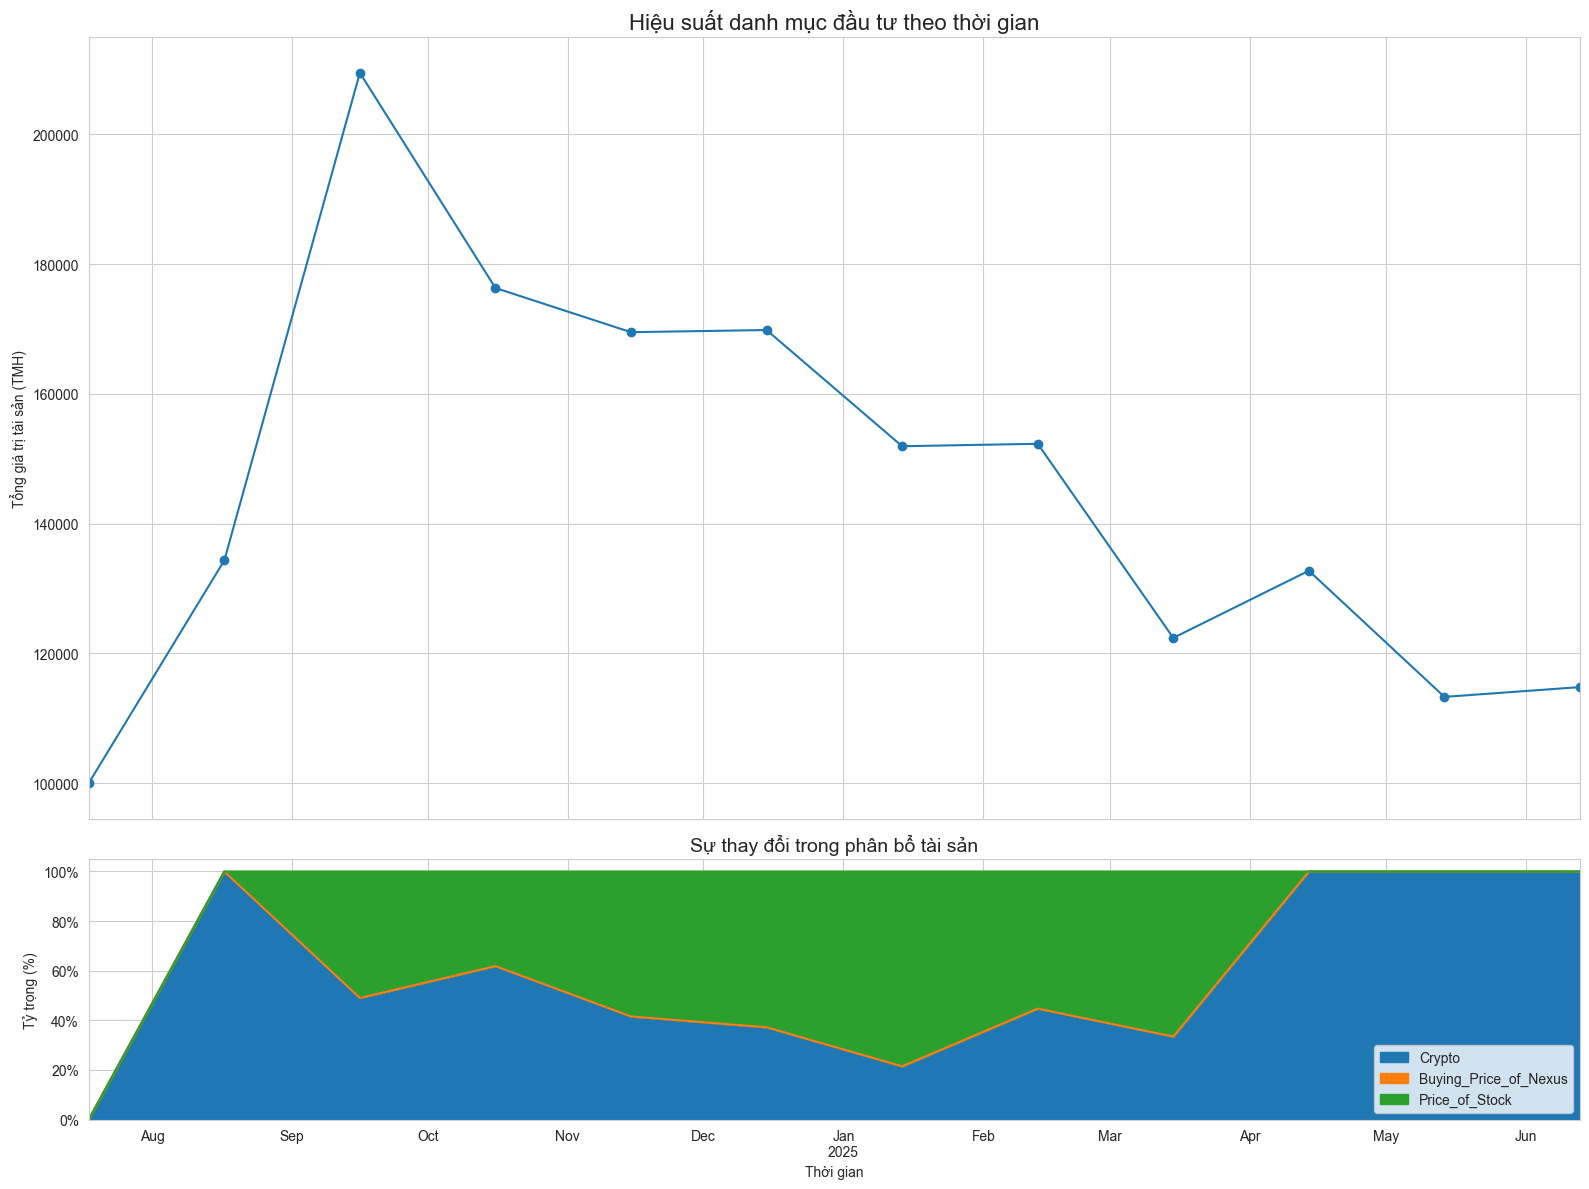


--- Ma trận trọng số (Weights Matrix) ---


'            Crypto  Buying_Price_of_Nexus  Price_of_Stock\n2024-07-18   0.00%                  0.00%           0.00%\n2024-08-17 100.00%                  0.00%           0.00%\n2024-09-16  49.03%                  0.00%          50.97%\n2024-10-16  61.88%                  0.00%          38.12%\n2024-11-15  41.57%                  0.00%          58.43%\n2024-12-15  37.19%                  0.00%          62.81%\n2025-01-14  21.46%                  0.00%          78.54%\n2025-02-13  44.73%                  0.00%          55.27%\n2025-03-15  33.45%                  0.00%          66.55%\n2025-04-14 100.00%                  0.00%           0.00%\n2025-05-14 100.00%                  0.00%           0.00%\n2025-06-13 100.00%                  0.00%           0.00%'

In [60]:
# Chạy mô phỏng
initial_capital = 100000
capital_over_time, weights_over_time = run_backtest(
    historical_df=df.set_index('Time'), # Đảm bảo Time là index
    initial_capital=initial_capital,
    forecast_func=forecast_monthly_params,
    optimizer_func=optimize_weights
)

# In kết quả cuối cùng
print("\n--- KẾT QUẢ KIỂM THỬ (BACKTESTING) ---")
print(f"Vốn ban đầu: {initial_capital:,.0f} TMH")
print(f"Vốn cuối kỳ: {capital_over_time.iloc[-1]:,.0f} TMH")
print(f"Tổng lợi nhuận: {(capital_over_time.iloc[-1]/initial_capital - 1):.2%}")

# Trực quan hóa kết quả
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Biểu đồ 1: Giá trị danh mục theo thời gian
axes[0].plot(capital_over_time.index, capital_over_time, marker='o', linestyle='-')
axes[0].set_title('Hiệu suất danh mục đầu tư theo thời gian', fontsize=16)
axes[0].set_ylabel('Tổng giá trị tài sản (TMH)')
axes[0].grid(True)

# Biểu đồ 2: Sự thay đổi trọng số phân bổ
weights_over_time.plot(kind='area', ax=axes[1], stacked=True)
axes[1].set_title('Sự thay đổi trong phân bổ tài sản', fontsize=14)
axes[1].set_ylabel('Tỷ trọng (%)')
axes[1].set_xlabel('Thời gian')
axes[1].set_yticklabels(['{:.0%}'.format(x) for x in axes[1].get_yticks()])

plt.tight_layout()
plt.show()

# In ra ma trận trọng số 12x4 (thực tế là 13x3 hoặc 12x3 tùy cách bạn chạy)
print("\n--- Ma trận trọng số (Weights Matrix) ---")
display((weights_over_time.round(4) * 100).to_string(float_format="%.2f%%"))


#### **Module 4: Module Mô phỏng & Kiểm thử (Simulation & Backtesting)**
*Mục đích: "Chạy" chiến lược đầu tư qua 12 tháng để đánh giá hiệu quả.*

* **Công việc 3.1: `generate_price_scenario()`**
    * **Mô tả**: Sử dụng mô hình **Geometric Brownian Motion (GBM)** từ file `scenario.ipynb` để tạo ra một chuỗi giá giả định cho 12 tháng tới. Điều này cho phép chúng ta kiểm thử chiến lược trên một kịch bản tương lai khả dĩ.
* **Công việc 3.2: `run_monthly_rebalancing_simulation(initial_capital, price_scenario)`**
    * **Mô tả**: Đây là hàm chính, thực hiện một vòng lặp trong 12 tháng. Tại **đầu mỗi tháng t**:
        1.  Lấy dữ liệu lịch sử đến thời điểm `t`.
        2.  Gọi hàm `forecast_monthly_params()` để lấy `μ` và `Σ` cho tháng `t`.
        3.  Gọi hàm `optimize_weights()` để tìm ra vector trọng số tối ưu `w_t`.
        4.  Lưu `w_t` vào ma trận kết quả.
        5.  Tính toán lợi nhuận thực tế trong tháng `t` dựa trên `price_scenario` và `w_t`, có trừ đi chi phí giao dịch.
        6.  Cập nhật tổng vốn và chuyển sang tháng `t+1`.


### 3. Cải tiến trong tương lai (Sau khi hoàn thành sườn chính)

1. Sau khi mô hình cơ sở hoạt động, chúng ta có thể tích hợp các quy tắc quản lý rủi ro nâng cao hơn:

    * **Cắt lỗ (Stop-loss)**: Trong vòng lặp của `run_monthly_rebalancing_simulation`, thay vì chỉ tính lợi nhuận cuối tháng, ta có thể kiểm tra giá hàng ngày. Nếu một tài sản giảm quá `x%`, hệ thống sẽ tự động bán và chuyển vốn về tiền mặt.
    * **Chốt lời (Take-profit)**: Tương tự, nếu tài sản đạt mức lợi nhuận kỳ vọng, có thể bán để hiện thực hóa lợi nhuận.


2. **Nâng cấp mô hình dự báo**: Sau khi có mô hình cơ sở, bạn có thể cải tiến bằng cách:
    * Thay thế việc tính phương sai/hiệp phương sai lịch sử bằng **mô hình GARCH** để có dự báo rủi ro `Σ` tốt hơn.
    * Thay thế việc tính lợi nhuận trung bình bằng **mô hình ARIMA** để có dự báo lợi nhuận `μ` tốt hơn.

3. **So sánh hiệu quả**: So sánh kết quả của chiến lược sau khi nâng cấp 
    * (ví dụ: Markowitz + GARCH) với mô hình cơ sở để xem việc sử dụng các mô hình dự báo phức tạp hơn có thực sự cải thiện hiệu suất đầu tư hay không.

Tóm lại, **Markowitz** là khung sườn để ra quyết định phân bổ, còn **ARIMA, GARCH, LightGBM** là các công cụ để giúp quyết định đó trở nên chính xác hơn.